In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/raw/dynamic_pricing.csv")

## Implementing the dynamic pricing strategy

The development of the dynamic pricing strategy is to adjust ride costs based on real-time data insights. The goal is to fine-tune fares in response to changes in demand and supply. During busy periods when demand outstrips supply, I'll raise prices to reflect the increased demand. Conversely, during quieter times when supply exceeds demand, we'll lower prices to encourage more bookings

**Base Price**
- Utilize the median historical cost for each vehicle type (Economy, Premium) as the base price.

- This reflects past pricing trends and provides a baseline for adjustments.

**Demand Multiplier**

- The demand multiplier represents how much the price should be adjusted based on the level of demand for rides.

- Calculate the demand ratio by comparing the number of riders for a specific ride to a percentile representing high demand in your data.

- Apply a logarithmic function (np.log1p) to create a smoother transition in the multiplier value as demand increases.

- Ensure a minimum impact on price with a threshold.
Cap the multiplier's impact with another threshold.

**Supply Multiplier**

- The supply multiplier represents how much the price should be adjusted based on the level of supply of drivers available for rides.

- Calculate the supply ratio by comparing the available drivers in the area to a percentile representing low supply in your data.

- Use the logarithmic function (np.log1p) for a smoother transition in the multiplier value.

- Set thresholds to control the multiplier's impact on price.

**Final Dynamic Price**

- Multiply the base price by the maximum of the demand multiplier and its lower threshold.
- Multiply the result by the maximum of the supply multiplier and its lower threshold.

In [3]:
# Define percentile for high/low demand and supply
high_demand_percentile = 0.8
low_demand_percentile = 0.2

high_supply_percentile = 0.9
low_supply_percentile = 0.1

# Get actual percentile values for demand and supply
actual_high_demand_percentile = df["Number_of_Riders"].quantile(high_demand_percentile)
actual_low_demand_percentile = df["Number_of_Riders"].quantile(low_demand_percentile)
actual_high_supply_percentile = df["Number_of_Drivers"].quantile(high_supply_percentile)
actual_low_supply_percentile = df["Number_of_Drivers"].quantile(low_supply_percentile)

# Define thresholds for demand and supply multipliers
demand_threshold_low = 1.1 
demand_threshold_high = 1.3
supply_threshold_low = 0.9
supply_threshold_high = 0.74

In [4]:
# Print the percentiles and column used
print(f"Column used for demand and supply calculations: {df.columns[1]}")
print(f"High Demand Percentile (actual value): {actual_high_demand_percentile:.2f}")
print(f"Low Demand Percentile (actual value): {actual_low_demand_percentile:.2f}")
print(f"High Supply Percentile (actual value): {actual_high_supply_percentile:.2f}")
print(f"Low Supply Percentile (actual value): {actual_low_supply_percentile:.2f}")
print(f"Demand Thresholds: Low = {demand_threshold_low}, High = {demand_threshold_high}")
print(f"Supply Thresholds: Low = {supply_threshold_low}, High = {supply_threshold_high}")

Column used for demand and supply calculations: Number_of_Drivers
High Demand Percentile (actual value): 85.20
Low Demand Percentile (actual value): 35.80
High Supply Percentile (actual value): 56.00
Low Supply Percentile (actual value): 7.00
Demand Thresholds: Low = 1.1, High = 1.3
Supply Thresholds: Low = 0.9, High = 0.74


In [5]:
def calculate_dynamic_price(historical_cost, num_riders, num_drivers):
  """
  Calculates the dynamic price for a ride

  Args:
      historical_cost: The historical cost of the ride
      num_riders: The number of riders requesting the ride
      num_drivers: The number of drivers available in the area

  Returns:
      The dynamic price for the ride
  """

  # Calculate demand multiplier with smoother transition
  demand_ratio = np.log1p(num_riders / df["Number_of_Riders"].quantile(high_demand_percentile))
  demand_multiplier = max(demand_ratio, demand_threshold_low) * (demand_threshold_high / demand_threshold_low) ** demand_ratio

  # Calculate supply multiplier with smoother transition
  supply_ratio = np.log1p(df["Number_of_Drivers"].quantile(high_supply_percentile) / num_drivers)
  supply_multiplier = max(supply_ratio, supply_threshold_low) * (supply_threshold_high / supply_threshold_low) ** supply_ratio

  # Adjusted ride cost with base price and multipliers
  adjusted_ride_cost = historical_cost * demand_multiplier * supply_multiplier

  return adjusted_ride_cost

### Understanding the Equation
The equation used for the demand and supply multipliers **( np.log1p(ratio) * (high_threshold / low_threshold) ** ratio )** involves calculating a ratio and then applying a transformation with np.log1p and raising it to the power of the ratio itself. Finally, it's scaled based on the defined high and low thresholds.

**Here's a breakdown of its components**

- **np.log1p(ratio):** This part uses the numpy.log1p function. It calculates the natural logarithm (ln) of 1 plus the ratio value. This function helps avoid issues with taking the logarithm of values close to zero.

- **(high_threshold / low_threshold) ** ratio:** This calculates the high_threshold divided by the low_threshold raised to the power of the ratio. This creates a scaling factor based on the initial ratio value.

- **Combining these parts:** Multiplying the log1p(ratio) with the scaling factor creates a smooth transition between the low and high thresholds as the ratio changes.

**Impact on Multipliers**

- When the ratio is low (indicating low demand or high supply), the log1p(ratio) term will be close to zero, and the scaling factor will have a smaller impact. This results in a multiplier closer to the low_threshold (e.g., 1.1 for demand, 0.9 for supply).

- As the ratio increases (indicating high demand or low supply), the log1p(ratio) term will increase, and the scaling factor will have a larger impact. This leads to a multiplier closer to the high_threshold (e.g., 1.3 for demand, 0.7 for supply).

**Benefit of this approach**

- **Smooth Transition:** The equation avoids abrupt jumps in the multiplier values as the ratio changes. This helps create a more gradual adjustment in prices based on demand and supply variations.

- **Flexibility:** By adjusting the low_threshold and high_threshold values, you can control how aggressively prices change in response to different demand and supply levels.

In [6]:
calculate_dynamic_price(284.257273, 90, 45)

270.97101674713224

In [7]:
# Calculate the adjusted cost for dynamic pricing for rides
df['Adjusted_Cost'] = df.apply(lambda row: calculate_dynamic_price(row['Historical_Cost_of_Ride'], row['Number_of_Riders'], row['Number_of_Drivers']), axis=1)

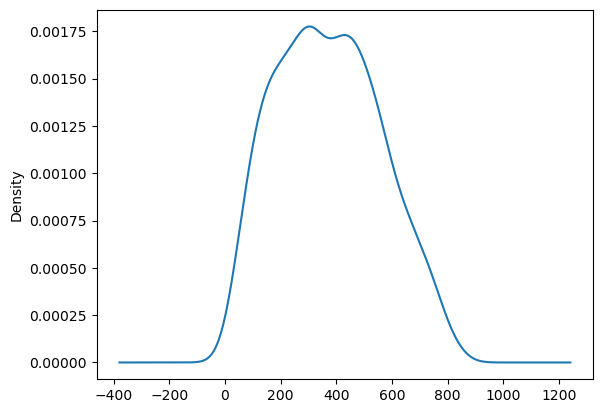

In [8]:
df['Historical_Cost_of_Ride'].plot(kind='density');

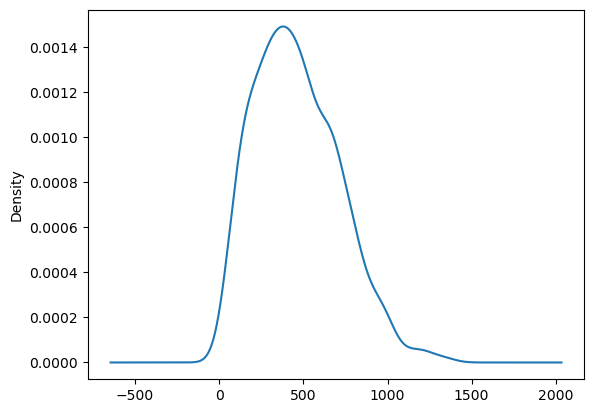

In [9]:
df['Adjusted_Cost'].plot(kind='density');

In [10]:
# Identifying the profits
df['Profit'] = df['Adjusted_Cost'] - df['Historical_Cost_of_Ride']

# Calculating profit percentages
df['Profit_Percentage'] = (df['Profit'] / df['Historical_Cost_of_Ride']) * 100

In [11]:
df.sample(10)

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Adjusted_Cost,Profit,Profit_Percentage
150,74,33,Urban,Silver,82,4.13,Afternoon,Economy,10,31.362081,31.288139,-0.073942,-0.235770
114,45,18,Rural,Gold,68,4.07,Morning,Economy,136,350.601203,443.760552,93.159350,26.571315
396,48,35,Rural,Gold,47,4.26,Morning,Economy,26,68.271745,64.129830,-4.141915,-6.066807
354,51,37,Rural,Regular,34,4.64,Afternoon,Economy,100,383.371177,350.974332,-32.396845,-8.450517
56,32,20,Rural,Silver,44,3.55,Night,Economy,68,301.622626,359.735841,58.113214,19.266862
950,44,18,Suburban,Gold,88,3.67,Night,Premium,50,199.839744,252.614212,52.774468,26.408395
638,65,51,Suburban,Gold,97,4.81,Night,Premium,144,588.136770,553.673889,-34.462881,-5.859671
404,29,16,Urban,Silver,75,4.11,Morning,Premium,80,371.124288,480.366982,109.242693,29.435609
910,82,20,Urban,Regular,59,3.99,Night,Premium,45,241.825956,306.055789,64.229832,26.560355
720,89,8,Urban,Gold,40,3.59,Morning,Premium,151,528.002490,905.917881,377.915391,71.574547


In [12]:
# Analyzing overall profit
average_profit_percentage = df['Profit_Percentage'].mean()
print(f"Average Profit Percentage: {average_profit_percentage:.2f}%")

Average Profit Percentage: 24.74%


- The average profit percentage is 24.74%. This suggests that the dynamic pricing strategy is effective in achieving profitability.

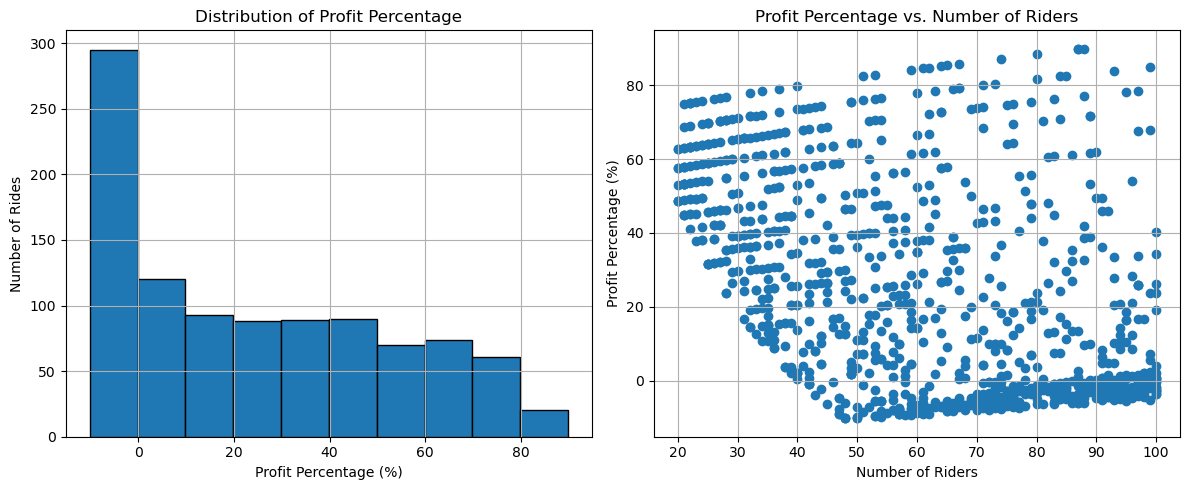

In [13]:
# Create subplots figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Profit Distribution Histogram
ax1.hist(df["Profit_Percentage"], bins=10, edgecolor="black")
ax1.set_xlabel("Profit Percentage (%)")
ax1.set_ylabel("Number of Rides")
ax1.set_title("Distribution of Profit Percentage")
ax1.grid(True)

# Profit vs. Number of Riders Scatter Plot
ax2.scatter(df["Number_of_Riders"], df["Profit_Percentage"])
ax2.set_xlabel("Number of Riders")
ax2.set_ylabel("Profit Percentage (%)")
ax2.set_title("Profit Percentage vs. Number of Riders")
ax2.grid(True)

# Adjust overall layout
plt.tight_layout()
plt.show()

In [14]:
# Profitable Rides (positive profit percentage)
profitable_rides = df[df['Profit_Percentage'] > 0]
print("Profitable Rides:")
profitable_rides.head()

Profitable Rides:


,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Adjusted_Cost,Profit,Profit_Percentage
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,516.434717,46.233485,9.832702
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,702.202113,122.520690,21.135866
8,79,14,Rural,Silver,71,3.74,Evening,Economy,128,501.412517,722.839391,221.426873,44.160619
9,42,6,Rural,Silver,21,3.85,Night,Premium,128,398.993365,693.838273,294.844908,73.897196
10,86,17,Urban,Regular,99,4.69,Morning,Economy,167,669.298626,906.341748,237.043122,35.416645


In [15]:
# Loss-Making Rides (negative profit percentage)
loss_rides = df[df['Profit_Percentage'] < 0]
print("\nLoss-Making Rides:")
loss_rides.head()


Loss-Making Rides:


,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Adjusted_Cost,Profit,Profit_Percentage
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,270.971017,-13.286256,-4.674025
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,157.709039,-16.165714,-9.297332
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,327.065489,-2.729980,-0.827780
5,59,35,Urban,Silver,83,3.51,Night,Economy,128,339.955361,323.592044,-16.363316,-4.813372
6,93,43,Suburban,Regular,44,4.41,Afternoon,Premium,16,104.061541,98.984861,-5.076680,-4.878536


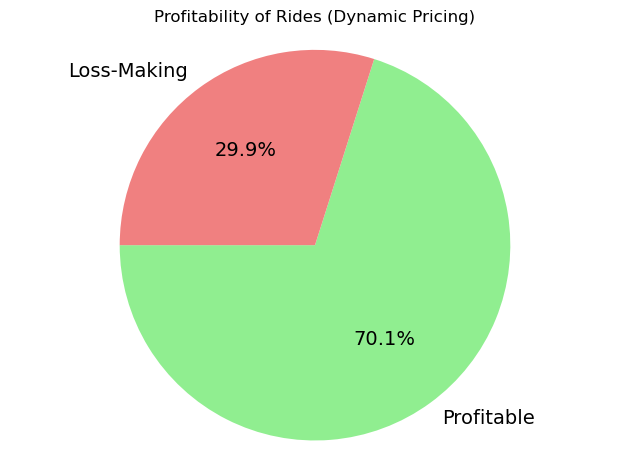

In [16]:
# Calculate percentages for the pie chart
total_rides = len(df)
profitable_percentage = (len(profitable_rides) / total_rides) * 100
loss_percentage = (len(loss_rides) / total_rides) * 100

# Create a pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    [profitable_percentage, loss_percentage],
    autopct="%1.1f%%",
    labels=['Profitable', 'Loss-Making'],
    startangle=180,
    colors=['lightgreen', 'lightcoral'],
    textprops=dict(size=14)
)

# Customize the plot for better presentation
ax.set_title('Profitability of Rides (Dynamic Pricing)')
plt.axis("equal") 
plt.tight_layout()
plt.show()

- The pie chart shows 70.1% of rides are profitable, indicating a good balance between attracting riders and maintaining profit margins.

In [17]:
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Adjusted_Cost,Profit,Profit_Percentage
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,270.971017,-13.286256,-4.674025
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,157.709039,-16.165714,-9.297332
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,327.065489,-2.729980,-0.827780
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,516.434717,46.233485,9.832702
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,702.202113,122.520690,21.135866


In [19]:
df.to_csv("../data/processed/processed_1.csv", index=False)